In [1]:
import pandas as pd
import numpy as np
import string
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [7]:
df = pd.read_csv(r'C:\Users\lilit\PycharmProjects\nlp-course-2025.1\Lilit Mnatsakanyan\data\spam.csv', encoding='latin-1')


In [8]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [9]:
df = df[['v1', 'v2']].copy()
df.columns = ['label', 'message']


In [10]:
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### preprocess

In [11]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    return tokens

df['tokens'] = df['message'].apply(preprocess_text)

In [12]:
df

,label,message,tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, i, dont, think, he, goes, to, usf, he, l..."
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,ham,Will Ì_ b going to esplanade fr home?,"[will, ì, b, going, to, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","[pity, was, in, mood, for, that, soany, other,..."
5570,ham,The guy did some bitching but I acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,..."


### train|test split

In [13]:
X = df['tokens']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Prior
##### P(Դաս) = (Դասին պատկանող հաղորդագրությունների քանակ) / (Ընդհանուր հաղորդագրությունների քանակ)



In [14]:
y_train_series = pd.Series(y_train)
total_docs_train = len(y_train_series)
spam_docs_count = y_train_series.value_counts()['spam']
ham_docs_count = y_train_series.value_counts()['ham']

prior_spam = spam_docs_count / total_docs_train
prior_ham = ham_docs_count / total_docs_train

### vocab & ham spam count

In [15]:
vocab = set()
for tokens in X_train:
    for word in tokens:
        vocab.add(word)

vocab_size = len(vocab)

spam_word_counts = Counter()
ham_word_counts = Counter()

total_words_spam = 0
total_words_ham = 0

for tokens, label in zip(X_train, y_train):
    if label == 'spam':
        for word in tokens:
            spam_word_counts[word] += 1
            total_words_spam += 1
    else:
        for word in tokens:
            ham_word_counts[word] += 1
            total_words_ham += 1

### Likelihoods
##### P(word | class) = (count(word, class) + 1) / (total_words(class) + vocab_size)


In [16]:
spam_likelihoods = {}
ham_likelihoods = {}

for word in vocab:
    p_word_spam = (spam_word_counts[word] + 1) / (total_words_spam + vocab_size)
    spam_likelihoods[word] = p_word_spam

    p_word_ham = (ham_word_counts[word] + 1) / (total_words_ham + vocab_size)
    ham_likelihoods[word] = p_word_ham

### Clasify
##### Score(դաս) = log(P(դաս)) + Σ log(P(յուրաքանչյուր_բառ | դաս))



In [17]:
def classify_message(message_tokens):
    log_prob_spam = np.log(prior_spam)
    log_prob_ham = np.log(prior_ham)

    for word in message_tokens:
        if word in vocab:
            log_prob_spam += np.log(spam_likelihoods[word])
            log_prob_ham += np.log(ham_likelihoods[word])

    if log_prob_spam > log_prob_ham:
        return 'spam'
    else:
        return 'ham'

### Test

In [18]:
predictions = [classify_message(tokens) for tokens in X_test]

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, pos_label='spam')
recall = recall_score(y_test, predictions, pos_label='spam')
f1 = f1_score(y_test, predictions, pos_label='spam')
conf_matrix = confusion_matrix(y_test, predictions, labels=['ham', 'spam'])


In [19]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9821
Precision: 0.9851
Recall: 0.8800
F1 Score: 0.9296


### Confusion Matrix

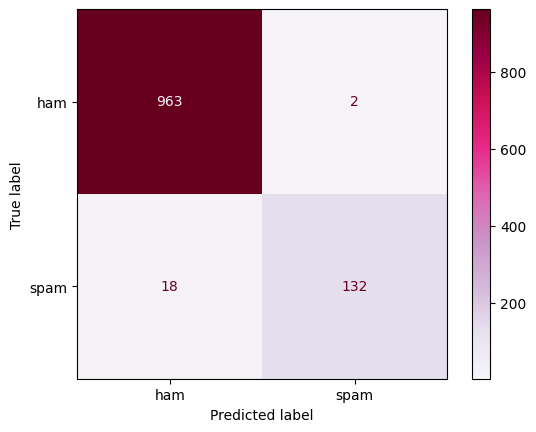

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['ham', 'spam'])

disp.plot(cmap='PuRd')
plt.show()